# Cross-match ZTF BTS and NGC

In this notebook, we demonstrate how to cross-match [Zwicky Transient Facility](https://ztf.caltech.edu) (ZTF) [Bright Transient Survey](https://sites.astro.caltech.edu/ztf/bts) (BTS) and [New General Catalogue](https://en.wikipedia.org/wiki/New_General_Catalogue) (NGC) using LSDB.

We are using the original survey datasets, as presented by the original survey providers, instead of catalogs that have already been converted to HATS format.

In [1]:
# Install astroquery, comment this line if you already have it
%pip install --quiet astroquery

Note: you may need to restart the kernel to use updated packages.


In [2]:
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.vizier import Vizier
from dask.distributed import Client

## 1. Download data

### 1.1. Download ZTF BTS and convert coordinates to degrees

We download the ZTF BTS data via HTTP, but must first convert the coordinates into degrees before loading as LSDB catalogs.

Of course ZTF looks much deeper than NGC galaxies from 19th century, so we filter ZTF transients by redshift.

In [3]:
%%time

ztf_bts = pd.read_csv(
    "http://sites.astro.caltech.edu/ztf/bts/explorer.php?format=csv",
    na_values="-",
)
ztf_bts = ztf_bts.query("redshift < 0.01")
coord = SkyCoord(ztf_bts["RA"], ztf_bts["Dec"], unit=("hourangle", "deg"))
ztf_bts["ra_deg"], ztf_bts["dec_deg"] = coord.ra.deg, coord.dec.deg
ztf_bts

CPU times: user 61.6 ms, sys: 18.5 ms, total: 80.1 ms
Wall time: 3.42 s


,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
228,ZTF18acbwaxk,SN2018hna,12:26:12.08,+58:18:50.8,503.03,r,13.9583,-16.13,61.205,48.696,12.509,SN II,0.00240,58.502394,0.031,186.550333,58.314111
232,ZTF18acbvgqw,SN2018htt,03:06:02.90,-15:36:41.7,441.75,g,13.9113,-19.07,25.333,10.316,15.017,SN Ia,0.00867,-56.742964,0.101,46.512083,-15.611583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9447,ZTF25aaugeio,SN2025mvn,13:13:27.85,+36:35:11.6,2850.78,r,15.3985,-15.11,>25.08,>15.06,>10.02,SN II,0.00291,79.453892,0.032,198.366042,36.586556
9477,ZTF25aauvber,SN2025ngs,15:35:16.68,+30:51:55.7,2847.77,r,15.5015,-16.73,>19.561,6.481,>13.08,SN II,0.00630,54.177709,0.078,233.819500,30.865472


### 1.2. Download NGC with `astroquery`

Please install astroquery first with `pip install astroquery` or `conda install -c conda-forge astroquery`.

In [4]:
%%time

vizier = Vizier(row_limit=50_000)
tables = vizier.get_catalogs("VII/118/ngc2000")
ngc = tables[0].to_pandas()
coord = SkyCoord(ngc["RAB2000"], ngc["DEB2000"], unit=("hourangle", "deg"))
ngc["ra_deg"], ngc["dec_deg"] = coord.ra.deg, coord.dec.deg
ngc

CPU times: user 685 ms, sys: 15.9 ms, total: 701 ms
Wall time: 702 ms


,Name,Type,RAB2000,DEB2000,Source,Const,l_size,size,mag,n_mag,Desc,ra_deg,dec_deg
0,I5370,Gx,00 00.1,+32 45,m,And,,0.7,15.0,p,"pB, S, R, stell N",0.025,32.750000
1,I5371,,00 00.2,+32 49,d,And,,NaN,NaN,,"F, vS, *15 att",0.050,32.816667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13224,7807,Gx,23 59.6,-18 51,c,Cet,,1.0,NaN,,"eF, pS, iF",359.900,-18.850000
13225,I5369,,23 59.8,+32 41,d,And,,NaN,NaN,,"F, S, R, N",359.950,32.683333


## 2. Plan cross-match job

LSDB is built upon [Dask](https://dask.org) and can be used with Dask distributed cluster. In this cell we just plan computations and do not actually run them.

In [5]:
%%time

matched_catalog = lsdb.crossmatch(
    ztf_bts,
    ngc,
    radius_arcsec=1200,
    ra_column="ra_deg",
    dec_column="dec_deg",
    suffixes=("_ztf", "_ngc"),
)
matched_catalog

CPU times: user 3.64 s, sys: 287 ms, total: 3.92 s
Wall time: 3.85 s


,ZTFID_ztf,IAUID_ztf,RA_ztf,Dec_ztf,peakt_ztf,peakfilt_ztf,peakmag_ztf,peakabs_ztf,duration_ztf,rise_ztf,fade_ztf,type_ztf,redshift_ztf,b_ztf,A_V_ztf,ra_deg_ztf,dec_deg_ztf,Name_ngc,Type_ngc,RAB2000_ngc,DEB2000_ngc,Source_ngc,Const_ngc,l_size_ngc,size_ngc,mag_ngc,n_mag_ngc,Desc_ngc,ra_deg_ngc,dec_deg_ngc,_dist_arcsec
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Order: 0, Pixel: 0",string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],string[pyarrow],float[pyarrow],float[pyarrow],string[pyarrow],string[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow]
"Order: 0, Pixel: 1",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 161010",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Order: 7, Pixel: 179663",...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## 3. Run LSDB pipeline

We create a dask client to run the crossmatch in parallel.

In [6]:
%%time

# Create default local cluster
with Client():
    matched_df = matched_catalog.compute()

# Let's output transient name, NGC name and angular distance between them
matched_df = matched_df[["IAUID_ztf", "Name_ngc", "_dist_arcsec", "RA_ztf", "Dec_ztf"]].sort_values(
    by=["_dist_arcsec"]
)
matched_df

CPU times: user 342 ms, sys: 93.9 ms, total: 436 ms
Wall time: 3.83 s


,IAUID_ztf,Name_ngc,_dist_arcsec,RA_ztf,Dec_ztf
_healpix_29,,,,,
1957242016251976064,SN2022xxf,3705,2.985601,11:30:05.93,+09:16:57.2
1827616204711960889,SN2024jlf,5690,6.309787,14:37:42.32,+02:17:04.1
...,...,...,...,...,...
190562289935449883,AT2020aabh,206,1081.99822,00:39:30.06,+40:31:00.8
184639843781841134,AT2022qpg,224,1193.179125,00:44:20.78,+41:23:10.8


We may have some false matches here, because NGC is too shallow for this task. However, if we sort the table by the cross-match distance, we can see the first one is a supernova ([SN2022xxf](https://www.wis-tns.org/object/2022xxf)) in the nearby galaxy NGC 3705.

## 4. Make some plot

This part is not related to LSDB and adopted from [PanSTARRS image this tutorial](https://spacetelescope.github.io/mast_notebooks/notebooks/PanSTARRS/PS1_image/PS1_image.html).

Now let's download host galaxy image from the PanSTARRS survey and plot it out (with SN location in the middle and marked with a "+")

In [7]:
def getimages(ra, dec, size=240, filters="grizy"):
    """Query ps1filenames.py service to get a list of images

    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """

    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits" "&filters={filters}").format(**locals())
    table = Table.read(url, format="ascii")
    return table


def get_ps1_image(url, size=240):
    """
    size: pixel number for 0.25 arcsec/pixel
    """
    from PIL import Image
    import requests
    from io import BytesIO

    try:
        r = requests.get(url)
        im = Image.open(BytesIO(r.content))
    except:
        print("Can't get ps1 image")
        im = None
    return im

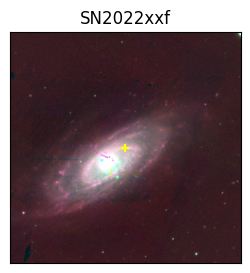

In [8]:
c = SkyCoord(
    matched_df["RA_ztf"].to_numpy()[0], matched_df["Dec_ztf"].to_numpy()[0], unit=("hourangle", "deg")
)
ra = c.ra.degree
dec = c.dec.degree
oid = matched_df["IAUID_ztf"].to_numpy()[0]
table = getimages(ra, dec, size=1200, filters="grizy")
url = (
    "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
    "ra={}&dec={}&size=1200&format=jpg&red={}&green={}&blue={}"
).format(ra, dec, table["filename"][0], table["filename"][1], table["filename"][2])
im = get_ps1_image(url)
fig, ax = plt.subplots(figsize=(7, 3))
if im is not None:
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(np.average(plt.xlim()), np.average(plt.ylim()), marker="+", color="yellow")
    ax.set_title(oid)
    plt.show()

## About

**Authors**: Konstantin Malanchev, Mi Dai

**Last updated on**: July 14, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).